In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

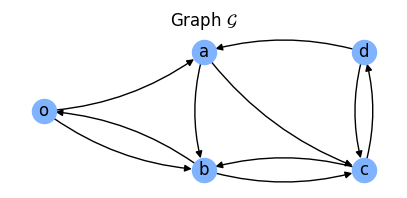

In [2]:
# build matrices and G graph
transition = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/3, 0, 1/3, 0]])

P = np.array([[lambda_ij/sum(node_i) for lambda_ij in node_i] for node_i in transition])
G = nx.DiGraph()
nodes_position_to_name = ['o', 'a', 'b', 'c', 'd']
for i, row in enumerate(transition):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], transition=element)
for i, row in enumerate(P):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], probability=element)
for i, node in enumerate(G.nodes()):
  G.add_node(node,omega=sum(transition[i,:]))

# plot graph
nodes_pos = {'o':(0,0),'a': (10,10), 'b':(10,-10), 'c':(20,-10),'d':(20,10)}
fig, ax = plt.subplots(figsize=(5,2))
nx.draw(G, with_labels=True, pos=nodes_pos, node_color="#80B3FF",connectionstyle="arc3,rad=0.15")
plt.title("Graph $\mathcal{G}$")
# fig.savefig('ex1_G.svg', format='svg', dpi=1200)
plt.show()

In [3]:
# random walk function
def RandomWalk(G, max_time, init='o', end='d'):
  arrived = False
  x = init
  x_next = init
  node_seq = [init]
  time = 0
  while not arrived and time < max_time:
    u = np.random.uniform(0,1,1)
    time += -1*np.log(u)/(G.nodes[x]["omega"])
    probabilities = [G[x][a]["probability"] for a in G.adj[x]]
    x_next = np.random.choice(G.adj[x], 1, p=probabilities)[0]
    node_seq.append(x_next)
    x = x_next
    if x == end:
      arrived = True

  return time

In [4]:
# 1(a)
num_simulations = 100000 # 100.000 to be sure

# save return times for all Random Walk simulations
times = np.zeros(num_simulations)
for i in range(num_simulations):
  times[i] = RandomWalk(G, 100, init='b', end='b')

# compute statistics from simulation results
avg_len = np.average(times)
std_len = np.std(times)
print(f"Average: {avg_len}, Standard Deviation: {std_len}")

Average: 4.595605615479147, Standard Deviation: 3.639518092525478


We proved that the return time for node i can be computed as:
\begin{equation}
E_i[T^+_i] = \frac{1}{w_i \cdot \bar{\pi_i}}
\end{equation}

In [ ]:
# 1(b)

# build P_bar matrix and omega vector
global_frequency = max([sum(node_i) for node_i in transition])
P_bar = np.array([[lambda_ij/global_frequency for lambda_ij in node_i] for node_i in transition])
for i in range(P_bar.shape[0]): P_bar[i,i] = 1 - sum(P_bar[i])
w = transition @ np.ones(5)

# find pi P_bar-invariant distribution
A = P_bar.T - np.eye(np.shape(P_bar)[0])
pi_bar = sp.linalg.null_space(A)
pi_bar /= sum(pi_bar)

# compute expected return time
# index 2 correspond to node b as required from the text
expected_time = 1 / (w[2] * pi_bar[2])
print(f"Expected return time (b -> b): {expected_time[0]:.5}")

Expected return time (b -> b): 4.6


In [ ]:
# 1(c)
num_simulations = 100000 # 100.000 to be sure

# save hitting times for all Random Walk simulations
times = np.zeros(num_simulations)
for i in range(num_simulations):
   times[i] = RandomWalk(G, 100, init='o', end='d')

# compute statistics from simulation results
avg_len = np.average(times)
std_len = np.std(times)
print(f"Average: {avg_len}, Standard Deviation: {std_len}")

Average: 10.437503493151354, Standard Deviation: 8.999775748958523


In [ ]:
# 1(d)

# compute expected hitting time
Q = P[:4,:4]
IQinv = np.linalg.inv(np.eye(4) - Q)
tao = IQinv @ (1/w[:4])
print(f"Expected hitting time (o -> d): {tao[0]:.5}")

Expected hitting time (o -> d): 10.767


De Groot


In [5]:
# 1(e)

# chiede "per ogni x(0)", possiamo simulare tanti x(0), tipo 100, e misurare la metrica globale"

w = transition @ np.ones(5)
P = np.eye(5) * (1/w) @ transition
# np.random.seed(42)
A = P.T - np.eye(np.shape(P)[0])
pi = sp.linalg.null_space(A)
pi /= sum(pi)
print(f"pi = \n{pi}")
x = np.random.random(5)
consensus = pi.T @ x
print(f"Consensus = {consensus}")
O = 25
for t in range(O):
  x = P @ x
print(f"Converges to {x}")

# error metric from consensus
RMSE = np.abs(np.sqrt(np.sum((consensus-x)**2)))
print(f"RMSE = {RMSE}")

pi = 
[[0.16153846]
 [0.18461538]
 [0.26923077]
 [0.23076923]
 [0.15384615]]
Consensus = [0.51420644]
Converges to [0.51420865 0.51421185 0.51419328 0.51422705 0.51418976]
RMSE = 3.017444754843649e-05


In [7]:
# 1(f)

# variance of uniform distribution: var = 1/12 * (b-a)^2
vars = [2, 1, 1, 1, 2] # o, a, b, c, d
var_predicted_consensus = sum(pi[i]**2 * vars[i] for i in range(len(vars)))
print(f"The theoretical predicted consensus is {var_predicted_consensus}")

# Now we simulate many consensus and compare the overall variance and average
amplitudes = [np.sqrt(vars[i]*12) for i in range(len(vars))] # value of (b-a)
medie = np.array([a/2 for a in amplitudes])
print(pi.T@medie)
num_simulations = 1000000 # 1.000.000 gives a Very good result (0.259x)
consensus_simulations = []
for i in range(num_simulations):
  x = np.array([amplitudes[i]*np.random.random(1)[0] for i in range(len(vars))])
  predicted_consensus = pi.T @ x
  consensus_simulations.append(predicted_consensus)

avg_consensus = np.mean(consensus_simulations)
var_consensus = np.std(consensus_simulations)**2

print(f"simulation avg = {avg_consensus}\nsimulation var = {var_consensus}")

The theoretical predicted consensus is [0.25934911]
[1.95832001]
simulation avg = 1.9582912868059985
simulation var = 0.25931845066474013


In [9]:
# 1(f) second way
variances = [2, 1, 1, 1, 2] # o, a, b, c, d
#theoretically speaking if the nodes x(t) have some variance. They are random variable with mean 0 and variance sigma^2.
#so the variance found in the consensus value is given by pi^2 ) * variance (both componentswise)
#because the variance of opinions is different among nodes
theoretical_consensus_variance = 0
for i in range(len(variances)):
  theoretical_consensus_variance += variances[i] * (pi[i])**2

num_simulations = 1000000 # 1.000.000 gives a Very good result (0.259x)
consensus_simulations = []
for i in range(num_simulations):
  for j in range(len(variances)):
    x[j] = np.random.normal(0, np.sqrt(variances[j]),1)
  predicted_consensus = pi.T @ x
  consensus_simulations.append(predicted_consensus)

avg_consensus = np.mean(consensus_simulations)
var_consensus = np.std(consensus_simulations)**2
print(f"avg = {avg_consensus}\nvar = {var_consensus}")
print(theoretical_consensus_variance)

avg = -0.0007493841483514781
var = 0.25939645747622153
[0.25934911]


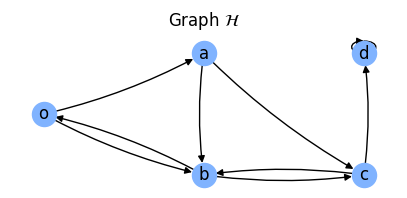

In [10]:
# 1(g)
H = G.copy()
H.remove_edge('d','a')
H.remove_edge('d','c')
H.add_edge('d','d')
fig, ax = plt.subplots(figsize=(5,2))
nx.draw(H, with_labels=True, pos=nodes_pos, node_color="#80B3FF",connectionstyle="arc3,rad=0.07")
# nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=nodes_pos, font_color='dimgrey', font_size=13)
plt.title("Graph $\mathcal{H}$")
fig.savefig('ex1_H.svg', format='svg', dpi=1200)
plt.show()

In [13]:
np.random.seed(42)
TH = transition.copy()
TH[4,1] = 0
TH[4,3] = 0
TH[4,4] = 1 #self-loop
print(TH)
omegaH = TH @ np.ones(5)
PH = (1/omegaH)*np.eye(5) @ TH
AH = PH.T - np.eye(np.shape(PH)[0])
piH = sp.linalg.null_space(AH)
piH /= sum(piH)

x = np.random.random(5)
consensus = piH.T @ x
print(f"The real consensus in which the dynamics converges is the sink value: {x[4]}")
O = 500 # qua mettiamo il numero che ci aspettiamo, la big O
for t in range(O):
  x = PH @ x
print(f"Converges to {x}")


[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.33333333 0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]
The real consensus in which the dynamics converges is the sink value: 0.15601864044243652
Converges to [0.15601864 0.15601864 0.15601864 0.15601864 0.15601864]


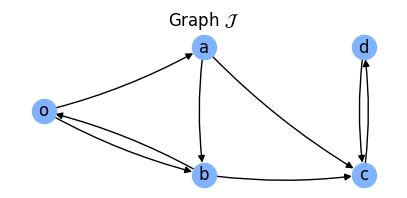

In [14]:
# 1(h)
J = G.copy()
J.remove_edge('c','b')
J.remove_edge('d','a')
fig, ax = plt.subplots(figsize=(5,2))
nx.draw(J, with_labels=True, pos=nodes_pos, node_color="#80B3FF",connectionstyle="arc3,rad=0.07")
# nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=nodes_pos, font_color='dimgrey', font_size=13)
plt.title("Graph $\mathcal{J}$")
fig.savefig('ex1_J.svg', format='svg', dpi=1200)
plt.show()

In [15]:
np.random.seed(42)
TJ = transition.copy()
TJ[3,2] = 0
TJ[4,1] = 0
print(f"Transition matrix for J =\n{TJ}")

omegaJ = TJ @ np.ones(5)
PJ = (1/omegaJ)*np.eye(5) @ TJ
AJ = PJ.T - np.eye(np.shape(PJ)[0])
piJ = sp.linalg.null_space(AJ)
piJ /= sum(piJ)

print(f"pi = \n{piJ}")
x = np.random.random(5)
print(f"x(0) = {x}")
consensus = piJ.T @ x
O = 100
print(f"Consensus = {consensus}")
for t in range(O):
  if t == O-1 or t == O-2 or t == O-3 or t == O-4 or t == O-5:
    print(t)
    [print(f"{xx:.4}", end= ", ") for xx in x]
    print()
  x = PJ @ x
print(t+1)
[print(f"{xx:.4}", end= ", ") for xx in x]
print()

Transition matrix for J =
[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.         0.66666667]
 [0.         0.         0.         0.33333333 0.        ]]
pi = 
[[ 0.00000000e+00]
 [ 5.42315377e-17]
 [-2.42105079e-17]
 [ 5.00000000e-01]
 [ 5.00000000e-01]]
x(0) = [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
Consensus = [0.37733856]
95
0.3572, 0.3572, 0.4779, 0.156, 0.5987, 
96
0.3975, 0.3975, 0.2767, 0.5987, 0.156, 
97
0.3572, 0.3572, 0.4779, 0.156, 0.5987, 
98
0.3975, 0.3975, 0.2767, 0.5987, 0.156, 
99
0.3572, 0.3572, 0.4779, 0.156, 0.5987, 
100
0.3975, 0.3975, 0.2767, 0.5987, 0.156, 
